In [ ]:
# Downloading the movielens datasets and Book-Crossing Dataset

# Movielens Dataset
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip
# Book-Crossing Dataset
!wget http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
!unzip BX-CSV-Dump.zip

--2022-10-10 12:22:26--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   721KB/s    in 1.3s    

2022-10-10 12:22:29 (721 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
--2022-10-10 12:22:29--  http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
Resolving www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)... 132.230.105.133
Connecting to 

In [ ]:
# Importing reuired packages
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dense, Dropout, merge
import pickle
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Reading required files
ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
book_rating_data = pd.read_csv("BX-Book-Ratings.csv", encoding='latin1', sep=';')

In [ ]:

# Snapshot of the loaded dataset
print(ratings.head())
print(movies.head())
print(book_rating_data.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X           

In [ ]:
# Renaming of various columns to create a uniform format
ratings["user"] = ratings["userId"]
ratings["item"] = ratings["movieId"]


book_rating_data["user"] = book_rating_data["User-ID"]
book_rating_data["item"] = book_rating_data["ISBN"]
book_rating_data["rating"] = book_rating_data["Book-Rating"]



#book_rating_data["user"] = book_rating_data["User-ID"].map(user_item_index(book_rating_data["User-ID"]))
#book_rating_data["item"] = book_rating_data["ISBN"].map(user_item_index(book_rating_data["ISBN"]))
#book_rating_data.rename(columns = {'Book-Rating':'rating'}, inplace=True)

In [ ]:
print(ratings.head())
print(book_rating_data.head())

   userId  movieId  rating  timestamp  user  item
0       1        1     4.0  964982703     1     1
1       1        3     4.0  964981247     1     3
2       1        6     4.0  964982224     1     6
3       1       47     5.0  964983815     1    47
4       1       50     5.0  964982931     1    50
   User-ID        ISBN  Book-Rating    user        item  rating
0   276725  034545104X            0  276725  034545104X       0
1   276726  0155061224            5  276726  0155061224       5
2   276727  0446520802            0  276727  0446520802       0
3   276729  052165615X            3  276729  052165615X       3
4   276729  0521795028            6  276729  0521795028       6


## To decide on the I-AutoRec and U-AutoRec

In [ ]:
# Maximum number of User/Item interaction
#MovieLens Dataset
movie_count = ratings.groupby('user').item.nunique()
print("Maximum No. of movies, a user has rated : {} out of {}".format(movie_count.max(), ratings["item"].nunique()))


user_count = ratings.groupby('movieId').userId.nunique()
print("Maximum No. of users, a movie has got ratings from : {} out of {}".format(user_count.max(), ratings["userId"].nunique()))



#Book Ratings dataset
ISBN_count = book_rating_data.groupby('User-ID').ISBN.nunique()
print("Maximum No. of books, users have rated : {} out of {}".format(ISBN_count.max(), book_rating_data["ISBN"].nunique()))


user_count = book_rating_data.groupby('item').user.nunique()
print("Maximum No. of users, books have got ratings from : {} out of {}".format(user_count.max(), book_rating_data["user"].nunique()))


Maximum No. of movies, a user has rated : 2698 out of 9724
Maximum No. of users, a movie has got ratings from : 329 out of 610
Maximum No. of books, users have rated : 13602 out of 340556
Maximum No. of users, books have got ratings from : 2502 out of 105283


In [ ]:
num_users = len(ratings["userId"].unique().tolist())
num_items = len(ratings["movieId"].unique().tolist())

br_num_users = len(book_rating_data["User-ID"].unique().tolist())
br_num_items = len(book_rating_data["ISBN"].unique().tolist())


print(num_users)
print(num_items)
print(br_num_users)
print(br_num_items)

610
9724
105283
340556


## Pivoting data to get interaction ratings at item level

In [ ]:
data = book_rating_data[book_rating_data['Book-Rating']!=0]
data = data[:37203]

In [ ]:
#data = book_rating_data[:67343]

# I-Autorec
final_data = data.pivot_table(index='item',columns='user',values='rating')
final_data = final_data.fillna(0)
final_data.values
final_data.shape
print(final_data.head())


user           8       9       10      12      14      16      17      19      \
item                                                                            
 9022906116       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0 907 062 008     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0/330/25864/8     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
00 14 02 5314     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
00000000          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

user           22      26      ...  278831  278832  278836  278843  278844  \
item                           ...                                           
 9022906116       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
0 907 062 008     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
0/330/25864/8     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
00 14 02 5314     0.0     0.0  ...     0.0

In [ ]:
# Normalise the ratings I-Autorec
#final_data_norm =(final_data - final_data.min(axis=1))/(final_data.max(axis=1)-final_data.min(axis =1).values)
final_data_norm = final_data.div(final_data.sum(axis=1), axis=0)
print(final_data.shape)
final_data_norm.fillna(0)
print(final_data_norm.shape)

(28295, 5650)
(28295, 5650)


In [ ]:
#I-Autorec
train_indices = int(0.7 * final_data_norm.shape[0])
x_train, x_val= (final_data_norm[:train_indices], final_data_norm[train_indices:])
final_data_norm.fillna(0)
print(x_train.shape)
print(x_val.shape)
print(x_train)

(19806, 5650)
(8489, 5650)
user           8       9       10      12      14      16      17      19      \
item                                                                            
 9022906116       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0 907 062 008     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0/330/25864/8     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
00 14 02 5314     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
00000000          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...               ...     ...     ...     ...     ...     ...     ...     ...   
089586763X        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0895870835        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0895871939        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
089587198X        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0

In [ ]:
# Model for the implementation of AutoEncoder
# Various hyperparameters were tested by changing the values and architectures within the code
class AutoRec(keras.Model):
  def __init__(self, embedding_size, **kwargs):
    super(AutoRec, self).__init__(**kwargs)
    self.encoder = keras.Sequential([layers.Input(shape=(5650,)),
                                     layers.Dense(256, activation='relu'),
                                     layers.Dropout(0.5),
                                     layers.Dense(128, activation='relu'),
                                     layers.Dropout(0.4),
                                     layers.Dense(64, activation='relu'),
                                     #layers.Dropout(0.2),
                                     layers.Dense(32, activation='relu'),
                                     layers.Dense(embedding_size, activation='relu')])
    self.decoder = keras.Sequential([layers.Dense(64, activation='relu'),
                                     layers.Dense(128, activation='relu'),
                                     layers.Dense(256, activation='relu'),
                                     layers.Dense(5650, activation='sigmoid')])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return(decoded)
    


In [ ]:
# Training Loop
Embedding_size = [8, 16, 32, 64] 


new = {'val_loss':[]}
for i in Embedding_size:
  model = AutoRec(i)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adagrad(lr=0.001))
  history = model.fit(
    x=x_train,
    y=x_train,
    batch_size=256,
    shuffle=True,
    epochs=15,
    verbose=1,
    validation_data = (x_val, x_val)
  )

  new['val_loss'].append(history.history['val_loss'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/15
78/78 [==============================] - 8s 41ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/15
78/78 [==============================] - 2s 22ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/15
78/78 [==============================] - 2s 22ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/15
78/78 [==============================] - 2s 22ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/15
78/78 [==============================] - 2s 22ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 10/15
78/78 [==============================] - 2s 22ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 11/

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/15
78/78 [==============================] - 4s 45ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/15
78/78 [==============================] - 2s 24ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 10/15
78/78 [==============================] - 2s 23ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 11/

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


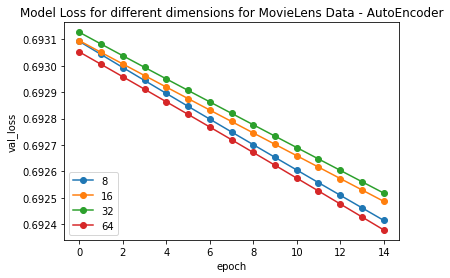

In [ ]:
# 'new_output' is a dataframe with stacked validation losses for different Embedding Dimensions
val_losses_data_ML = pd.DataFrame(new)
val_losses_data_ML['Dim'] = Embedding_size
val_losses_data_ML.set_index(['Dim'])


for i, v in val_losses_data_ML.iterrows():
  plt.plot(val_losses_data_ML['val_loss'][i], '-o')
plt.title('Model Loss for different dimensions for MovieLens Data - AutoEncoder')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(val_losses_data_ML['Dim'], loc='lower left')
plt.show()

In [ ]:
# Change the dataset name as per the interest - movielens dataset > ratings, book rating dataset > book_rating_data

rating = ratings
rating["rating"] = rating["rating"].values.astype(np.float32)

min_rating = min(rating["rating"])
max_rating = max(rating["rating"])

# Creation of train and validation dataset
data = rating.sample(frac=1, random_state=1)
x = data[["user","item"]].values
y = data["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
#y = data["rating"]


train_indices = int(0.7 * data.shape[0])

x_train, x_val, y_train, y_val = (x[:train_indices], x[train_indices:], y[:train_indices], y[train_indices:])

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(70585, 2)
(70585,)
(30251, 2)
(30251,)


In [ ]:
# Model creation using AutoRec
# Various iteration were carried out by changing the hyperparameters in the code
# Model for the implementation of AutoEncoder
# Various hyperparameters were tested by changing the values and architectures within the code
class AutoRec(keras.Model):
  def __init__(self, embedding_size, **kwargs):
    super(AutoRec, self).__init__(**kwargs)
    self.encoder = keras.Sequential([layers.Input(shape=(5650,)),
                                     layers.Dense(256, activation='relu'),
                                     layers.Dropout(0.5),
                                     layers.Dense(128, activation='relu'),
                                     layers.Dropout(0.4),
                                     layers.Dense(64, activation='relu'),
                                     #layers.Dropout(0.2),
                                     layers.Dense(32, activation='relu'),
                                     layers.Dense(embedding_size, activation='relu')])
    self.decoder = keras.Sequential([layers.Dense(64, activation='relu'),
                                     layers.Dense(128, activation='relu'),
                                     layers.Dense(256, activation='relu'),
                                     layers.Dense(5650, activation='sigmoid')])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return(decoded)
    


In [ ]:
# Training Loop
Embedding_size = [8, 16, 32, 64] 


new = {'val_loss':[]}
for i in Embedding_size:
  model = GMF(num_users, num_items, i)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adagrad(lr=0.0001))
  history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val)
  )

  new['val_loss'].append(history.history['val_loss'])

When the same architecture implemented using Book Crossing data. The validation losses across the architectures and epochs remain unchanged. One of the reasons concluded was the excessive presence of zero values in user-item interacion matrix. This hypothesis is discussed in the thesis. 